In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import collections
import pysam
import glob
import re
import os

In [4]:
bed_df = pd.read_csv(
    '../plotting/buildup_plots/MERFISH_genes.bed',
    sep = ' ',
)
bed_df

,#chr,start,end,gene,strand
0,chr1,5588466,5606131,Oprk1,+
1,chr1,12692277,12861192,Sulf1,+
2,chr1,12866549,12992650,Slco5a1,-
3,chr1,42695768,42703176,Pou3f3,+
4,chr1,56793981,56978650,Satb2,-
...,...,...,...,...,...
237,chr19,40928927,40994535,Blnk,-
238,chr19,41061710,41077113,Opalin,-
239,chrX,73483602,73495933,Bgn,+
240,chrX,137570608,138846946,Il1rapl2,+


In [1]:
import pandas as pd

full_gtf = pd.read_csv(
    '/oak/stanford/groups/horence/rob/readzs_fork/gencode.vM10.annotation.gff3',
    comment = '#',
    sep = '\t',
    header = None,
    names = ['chrom','source','kind','start','stop','dot1','strand','dot2','info'],
)

full_gtf['gene_name'] = full_gtf['info'].str.extract('gene_name=(.*?);')
full_gtf['gene_id'] = full_gtf['info'].str.extract('gene_id=(.*?);')

gene_df = full_gtf.loc[full_gtf['kind'].eq('gene'),['gene_name','gene_id','chrom','source','start','stop','strand']]
gene_df.to_csv('/oak/stanford/groups/horence/rob/readzs_fork/mouse_gene_name_ids.csv',index=False)

In [5]:
full_gtf = pd.read_csv(
    '/oak/stanford/groups/horence/rob/readzs_fork/gencode.vM10.annotation.gff3',
    comment = '#',
    sep = '\t',
    header = None,
    names = ['chrom','source','kind','start','stop','dot1','strand','dot2','info'],
)

#Only keep MERFISH gene rows
full_gtf['gene_name'] = full_gtf['info'].str.extract('gene_name=(.*?);')
merf_gtf = full_gtf[full_gtf['gene_name'].isin(bed_df['gene'])]

#subset to features of interest
merf_gtf = merf_gtf[merf_gtf['kind'].isin(['exon','five_prime_UTR','three_prime_UTR'])]

#Pull out the Transcript IDs
merf_gtf['transcript_id'] = merf_gtf['info'].str.extract('transcript_id=(.*?);')

#Remove transcripts without both a 5' and 3' UTR
merf_gtf = merf_gtf.groupby('transcript_id').filter(lambda g: g['kind'].nunique() >= 3)

merf_gtf.head()

,chrom,source,kind,start,stop,dot1,strand,dot2,info,gene_name,transcript_id
845,chr1,HAVANA,exon,5588493,5588663,.,+,.,ID=exon:ENSMUST00000160777.7:1;Parent=ENSMUST0...,Oprk1,ENSMUST00000160777.7
846,chr1,HAVANA,exon,5589035,5589305,.,+,.,ID=exon:ENSMUST00000160777.7:2;Parent=ENSMUST0...,Oprk1,ENSMUST00000160777.7
849,chr1,HAVANA,exon,5598590,5598942,.,+,.,ID=exon:ENSMUST00000160777.7:3;Parent=ENSMUST0...,Oprk1,ENSMUST00000160777.7
851,chr1,HAVANA,exon,5602252,5606131,.,+,.,ID=exon:ENSMUST00000160777.7:4;Parent=ENSMUST0...,Oprk1,ENSMUST00000160777.7
854,chr1,HAVANA,five_prime_UTR,5588493,5588663,.,+,.,ID=UTR5:ENSMUST00000160777.7;Parent=ENSMUST000...,Oprk1,ENSMUST00000160777.7


In [5]:
#All this filtering causes some genes to be lost, but I think its ok for now
set(bed_df['gene']).difference(merf_gtf['gene_name'])

{'5031425F14Rik',
 'Alk',
 'Ankfn1',
 'B4galnt3',
 'Cdh9',
 'Cntnap5b',
 'Dscaml1',
 'Fbxl7',
 'Shisa9',
 'Trpc6'}

In [6]:
merf_gtf.head(10)

,chrom,source,kind,start,stop,dot1,strand,dot2,info,gene_name,transcript_id
845,chr1,HAVANA,exon,5588493,5588663,.,+,.,ID=exon:ENSMUST00000160777.7:1;Parent=ENSMUST0...,Oprk1,ENSMUST00000160777.7
846,chr1,HAVANA,exon,5589035,5589305,.,+,.,ID=exon:ENSMUST00000160777.7:2;Parent=ENSMUST0...,Oprk1,ENSMUST00000160777.7
849,chr1,HAVANA,exon,5598590,5598942,.,+,.,ID=exon:ENSMUST00000160777.7:3;Parent=ENSMUST0...,Oprk1,ENSMUST00000160777.7
851,chr1,HAVANA,exon,5602252,5606131,.,+,.,ID=exon:ENSMUST00000160777.7:4;Parent=ENSMUST0...,Oprk1,ENSMUST00000160777.7
854,chr1,HAVANA,five_prime_UTR,5588493,5588663,.,+,.,ID=UTR5:ENSMUST00000160777.7;Parent=ENSMUST000...,Oprk1,ENSMUST00000160777.7
855,chr1,HAVANA,five_prime_UTR,5589035,5589048,.,+,.,ID=UTR5:ENSMUST00000160777.7;Parent=ENSMUST000...,Oprk1,ENSMUST00000160777.7
856,chr1,HAVANA,three_prime_UTR,5602785,5606131,.,+,.,ID=UTR3:ENSMUST00000160777.7;Parent=ENSMUST000...,Oprk1,ENSMUST00000160777.7
858,chr1,HAVANA,exon,5588557,5588663,.,+,.,ID=exon:ENSMUST00000027038.10:1;Parent=ENSMUST...,Oprk1,ENSMUST00000027038.10
859,chr1,HAVANA,exon,5589005,5589305,.,+,.,ID=exon:ENSMUST00000027038.10:2;Parent=ENSMUST...,Oprk1,ENSMUST00000027038.10
862,chr1,HAVANA,exon,5598590,5598942,.,+,.,ID=exon:ENSMUST00000027038.10:3;Parent=ENSMUST...,Oprk1,ENSMUST00000027038.10


In [7]:
merf_gtf[merf_gtf['kind'].eq('three_prime_UTR')]['gene_name'].nunique()

232

In [8]:
utrs = merf_gtf[merf_gtf['kind'].eq('three_prime_UTR')]
utrs.head()

,chrom,source,kind,start,stop,dot1,strand,dot2,info,gene_name,transcript_id
856,chr1,HAVANA,three_prime_UTR,5602785,5606131,.,+,.,ID=UTR3:ENSMUST00000160777.7;Parent=ENSMUST000...,Oprk1,ENSMUST00000160777.7
869,chr1,HAVANA,three_prime_UTR,5602785,5602866,.,+,.,ID=UTR3:ENSMUST00000027038.10;Parent=ENSMUST00...,Oprk1,ENSMUST00000027038.10
880,chr1,HAVANA,three_prime_UTR,5602785,5604014,.,+,.,ID=UTR3:ENSMUST00000160339.1;Parent=ENSMUST000...,Oprk1,ENSMUST00000160339.1
4099,chr1,HAVANA,three_prime_UTR,12858843,12861192,.,+,.,ID=UTR3:ENSMUST00000177608.7;Parent=ENSMUST000...,Sulf1,ENSMUST00000177608.7
4146,chr1,HAVANA,three_prime_UTR,12858843,12860371,.,+,.,ID=UTR3:ENSMUST00000180062.7;Parent=ENSMUST000...,Sulf1,ENSMUST00000180062.7


In [9]:
utrs['gene_name'].eq('Timp3').any()

True

In [10]:
utrs.to_csv('/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/plotting/three_prime_UTRs.csv',index=None)

In [11]:
#Collect the different mouse/ont BAM paths
bam_stem = '/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_mapping/merged_by_mouse_celltype'

mice = set()
onts = set()
mouse_onts = collections.defaultdict(dict)

for p in glob.glob(os.path.join(bam_stem,'*.bam')):
    name = os.path.basename(p)
    mouse = name.split('_')[0]
    ont = re.findall('Mouse._(.*).bam',name)[0]
    mice.add(mouse)
    onts.add(ont)
    mouse_onts[mouse][ont] = p

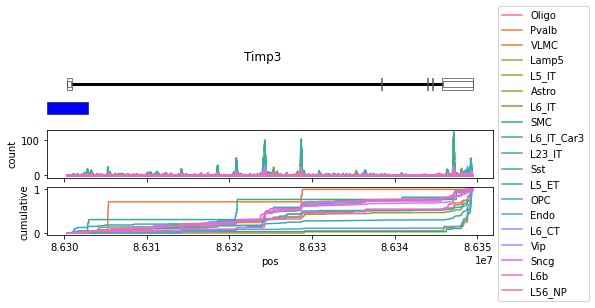

In [12]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

#Example plot a single gene for testing
gene = 'Timp3'
gene_gtf = merf_gtf[merf_gtf['gene_name'].eq(gene)]
chrom = gene_gtf['chrom'].unique()[0]

fig,axs = plt.subplots(
    nrows=3,ncols=1,sharex=True,
    figsize=(8,3),
)

xmin,ymin,xmax,ymax = None,0,None,None

for i,(transcript_id,transcript_df) in enumerate(gene_gtf.groupby('transcript_id')):
    y = 2*(i+1)
    #Draw a line for the intro from the total start to total end
    min_x_transcript = transcript_df['start'].min()
    max_x_transcript = transcript_df['stop'].max()
    
    intron_line = Rectangle(
        (min_x_transcript, y - 0.1),
        max_x_transcript - min_x_transcript, 0.2,
        linewidth=1,edgecolor='k',facecolor='k',
    )
    axs[0].add_patch(intron_line)
        
    prev_5UTR = False
    prev_3UTR = False
    for _,feature in transcript_df.iterrows():
        height = 1
        #Sometimes there are multiple 5' and 3' UTRs for a single transcript (???) just use the first of each for now
        if feature['kind'] == 'five_prime_UTR':
            if prev_5UTR:
                continue
            prev_5UTR = True
            height = 0.5

        if feature['kind'] == 'three_prime_UTR':
            if prev_3UTR:
                continue
            prev_3UTR = True
            height = 0.5

        ymax = y+1
            
        x = feature['start']
        xmin = min(xmin,x) if xmin else x
        
        width = feature['stop']-feature['start']
        xmax = max(xmax,feature['stop']) if xmax else feature['stop']
        
        rect = Rectangle(
            (x, y - height/2),
            width, height,
            linewidth=0.5,edgecolor='k',facecolor='white',
        )
        axs[0].add_patch(rect)

gene_width = xmax-xmin
view_width = 1.1*gene_width
offset = (view_width-gene_width)/2

scale_bar_size = 5000
scale = Rectangle(
    (xmin-offset, -0.5),
    scale_bar_size, 1,
    linewidth=0.5,edgecolor='k',facecolor='blue',
)
axs[0].add_patch(scale)

axs[0].set_xlim(xmin-offset,xmax+offset)
axs[0].set_ylim(-1,ymax)
axs[0].axis('off')


#Now plotting the CDFs of all the cell-types for just mouse1 (as an example)
ws = 10 #how much smoothing to do for the lineplots
count_df = pd.DataFrame()

for ont,path in mouse_onts['Mouse1'].items():
    tot_counts = 0
    pos_counts = {p:0 for p in range(xmin//ws*ws,xmax//ws*ws+ws,ws)}
    with pysam.AlignmentFile(path) as bam:
        for r in bam.fetch(chrom,xmin,xmax):
            if r.pos < xmin or r.pos > xmax:
                continue
            pos_counts[r.pos//ws*ws] += 1
            tot_counts += 1

    if tot_counts <= 0:
        continue
        
    ont_df = pd.DataFrame({'pos':pos_counts.keys(),'count':pos_counts.values()})
    ont_df['ont'] = ont
    
    count_df = pd.concat((count_df,ont_df))

count_df['cumulative'] = count_df.groupby('ont')['count'].cumsum()
count_df['cumulative'] = count_df.groupby('ont')['cumulative'].transform(lambda v: v/v.max())

sns.lineplot(
    x = 'pos',
    y = 'count',
    hue = 'ont',
    data = count_df,
    ax = axs[1],
)
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.lineplot(
    x = 'pos',
    y = 'cumulative',
    hue = 'ont',
    data = count_df,
    ax = axs[2],
    legend = False,
)

plt.suptitle(gene)
plt.show()
plt.close()

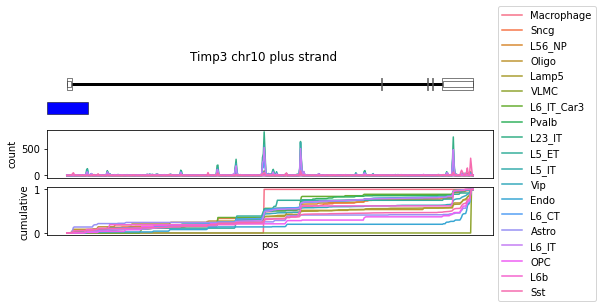

In [13]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle


def plot_read_buildup(gene,ann,bam_paths,ws=10,scale_bar_size=5000):

    gene_gtf = ann[ann['gene_name'].eq(gene)]
    chrom = gene_gtf['chrom'].unique()[0]
    strand = 'plus' if gene_gtf['strand'].unique()[0] == '+' else 'minus'

    fig,axs = plt.subplots(
        nrows=3,ncols=1,sharex=True,
        figsize=(8,3),
    )

    xmin,ymin,xmax,ymax = None,0,None,None

    for i,(transcript_id,transcript_df) in enumerate(gene_gtf.groupby('transcript_id')):
        y = 2*(i+1)
        #Draw a line for the intro from the total start to total end
        min_x_transcript = transcript_df['start'].min()
        max_x_transcript = transcript_df['stop'].max()

        intron_line = Rectangle(
            (min_x_transcript, y - 0.1),
            max_x_transcript - min_x_transcript, 0.2,
            linewidth=1,edgecolor='k',facecolor='k',
        )
        axs[0].add_patch(intron_line)

        prev_5UTR = False
        prev_3UTR = False
        for _,feature in transcript_df.iterrows():
            height = 1
            #Sometimes there are multiple 5' and 3' UTRs for a single transcript (???) just use the first of each for now
            if feature['kind'] == 'five_prime_UTR':
                if prev_5UTR:
                    continue
                prev_5UTR = True
                height = 0.5

            if feature['kind'] == 'three_prime_UTR':
                if prev_3UTR:
                    continue
                prev_3UTR = True
                height = 0.5

            ymax = y+1

            x = feature['start']
            xmin = min(xmin,x) if xmin else x

            width = feature['stop']-feature['start']
            xmax = max(xmax,feature['stop']) if xmax else feature['stop']

            rect = Rectangle(
                (x, y - height/2),
                width, height,
                linewidth=0.5,edgecolor='k',facecolor='white',
            )
            axs[0].add_patch(rect)

    gene_width = xmax-xmin
    view_width = 1.1*gene_width
    offset = (view_width-gene_width)/2

    scale = Rectangle(
        (xmin-offset, -0.5),
        scale_bar_size, 1,
        linewidth=0.5,edgecolor='k',facecolor='blue',
    )
    axs[0].add_patch(scale)

    axs[0].set_xlim(xmin-offset,xmax+offset)
    axs[0].set_ylim(-1,ymax)
    axs[0].axis('off')


    #Now plotting the CDFs of all the cell-types for just mouse1 (as an example)
    count_df = pd.DataFrame()

    for ont,path in bam_paths['Mouse4'].items():
        tot_counts = 0
        pos_counts = {p:0 for p in range(xmin//ws*ws,xmax//ws*ws+ws,ws)}
        with pysam.AlignmentFile(path) as bam:
            for r in bam.fetch(chrom,xmin,xmax):
                if r.pos < xmin or r.pos > xmax:
                    continue
                pos_counts[r.pos//ws*ws] += 1
                tot_counts += 1

        if tot_counts <= 0:
            continue

        ont_df = pd.DataFrame({'pos':pos_counts.keys(),'count':pos_counts.values()})
        ont_df['ont'] = ont

        count_df = pd.concat((count_df,ont_df))

    count_df['cumulative'] = count_df.groupby('ont')['count'].cumsum()
    count_df['cumulative'] = count_df.groupby('ont')['cumulative'].transform(lambda v: v/v.max())

    sns.lineplot(
        x = 'pos',
        y = 'count',
        hue = 'ont',
        data = count_df,
        ax = axs[1],
    )
    axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    sns.lineplot(
        x = 'pos',
        y = 'cumulative',
        hue = 'ont',
        data = count_df,
        ax = axs[2],
        legend = False,
    )
    plt.xticks([])
    plt.suptitle('{} {} {} strand'.format(gene,chrom,strand))
    return fig
    
    
fig = plot_read_buildup('Timp3',merf_gtf,mouse_onts,ws=100,scale_bar_size=5000)
plt.show()
plt.close()

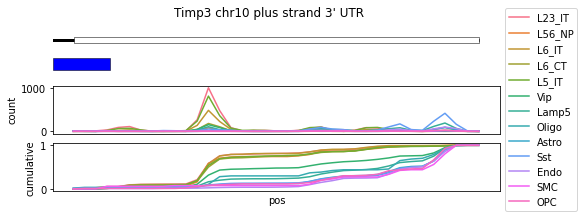

In [16]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle


def plot_read_buildup_3UTR(gene,ann,bam_paths,ws=10,count_threshold=0,scale_bar_size=5000):

    gene_gtf = ann[ann['gene_name'].eq(gene)]
    chrom = gene_gtf['chrom'].unique()[0]
    strand = 'plus' if gene_gtf['strand'].unique()[0] == '+' else 'minus'

    fig,axs = plt.subplots(
        nrows=3,ncols=1,sharex=True,
        figsize=(8,3),
    )

    xmin,ymin,xmax,ymax = None,0,None,None

    for i,(transcript_id,transcript_df) in enumerate(gene_gtf.groupby('transcript_id')):
        y = 2*(i+1)
        #Draw a line for the intro from the total start to total end
        min_x_transcript = transcript_df['start'].min()
        max_x_transcript = transcript_df['stop'].max()

        intron_line = Rectangle(
            (min_x_transcript, y - 0.1),
            max_x_transcript - min_x_transcript, 0.2,
            linewidth=1,edgecolor='k',facecolor='k',
        )
        axs[0].add_patch(intron_line)

        prev_5UTR = False
        prev_3UTR = False
        for _,feature in transcript_df.iterrows():
            #NOTE!! JUST PRINTING 3' UTR
            if feature['kind'] != 'three_prime_UTR':
                continue
            
            height = 1
            #Sometimes there are multiple 5' and 3' UTRs for a single transcript??? just using the first
            if feature['kind'] == 'five_prime_UTR':
                if prev_5UTR:
                    continue
                prev_5UTR = True
                height = 0.5

            if feature['kind'] == 'three_prime_UTR':
                if prev_3UTR:
                    continue
                prev_3UTR = True
                height = 0.5

            ymax = y+1

            x = feature['start']
            xmin = min(xmin,x) if xmin else x

            width = feature['stop']-feature['start']
            xmax = max(xmax,feature['stop']) if xmax else feature['stop']

            rect = Rectangle(
                (x, y - height/2),
                width, height,
                linewidth=0.5,edgecolor='k',facecolor='white',
            )
            axs[0].add_patch(rect)

    gene_width = xmax-xmin
    view_width = 1.1*gene_width
    offset = (view_width-gene_width)/2

    scale = Rectangle(
        (xmin-offset, -0.5),
        scale_bar_size, 1,
        linewidth=0.5,edgecolor='k',facecolor='blue',
    )
    axs[0].add_patch(scale)

    axs[0].set_xlim(xmin-offset,xmax+offset)
    axs[0].set_ylim(-1,ymax)
    axs[0].axis('off')


    #Now plotting the CDFs of all the cell-types for just mouse1 (as an example)
    count_df = pd.DataFrame()

    for ont,path in bam_paths['Mouse1'].items():
        tot_counts = 0
        pos_counts = {p:0 for p in range(xmin//ws*ws,xmax//ws*ws+ws,ws)}
        with pysam.AlignmentFile(path) as bam:
            for r in bam.fetch(chrom,xmin,xmax):
                if r.pos < xmin or r.pos > xmax:
                    continue
                pos_counts[r.pos//ws*ws] += 1
                tot_counts += 1

        if tot_counts <= count_threshold:
            continue

        ont_df = pd.DataFrame({'pos':pos_counts.keys(),'count':pos_counts.values()})
        ont_df['ont'] = ont

        count_df = pd.concat((count_df,ont_df))

    #Sometimes a 3' UTR won't have any ontologies with enough reads
    #in which case don't make a plot
    if len(count_df) == 0:
        plt.close()
        return None
        
    count_df['cumulative'] = count_df.groupby('ont')['count'].cumsum()
    count_df['cumulative'] = count_df.groupby('ont')['cumulative'].transform(lambda v: v/v.max())
    
    ont_to_median_pos = count_df.groupby('ont')['cumulative'].apply(lambda c: sum(c < 0.5))
    count_df['median_pos'] = count_df['ont'].map(ont_to_median_pos)
    count_df = count_df.sort_values('median_pos')

    sns.lineplot(
        x = 'pos',
        y = 'count',
        hue = 'ont',
        data = count_df,
        ax = axs[1],
    )
    axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    sns.lineplot(
        x = 'pos',
        y = 'cumulative',
        hue = 'ont',
        data = count_df,
        ax = axs[2],
        legend = False,
    )
    plt.xticks([])
    plt.suptitle("{} {} {} strand 3' UTR".format(gene,chrom,strand))
    return fig
    
    
fig = plot_read_buildup_3UTR('Timp3',merf_gtf,mouse_onts,ws=100,count_threshold=50,scale_bar_size=500)
fig.savefig('timp3_3UTR_CDF.svg')
plt.show()
plt.close()

In [7]:
merf_gtf.to_csv('/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/plotting/merf_gtf.csv',index=None)

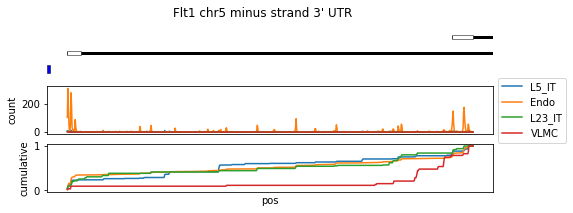

In [11]:
fig = plot_read_buildup_3UTR('Flt1',merf_gtf,mouse_onts,ws=100,count_threshold=50,scale_bar_size=500)
fig.savefig('flt1_3UTR_CDF.svg')
plt.show()
plt.close()

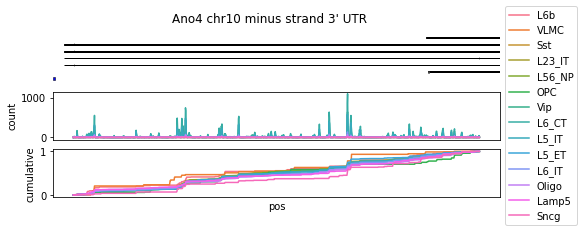

In [17]:
fig = plot_read_buildup_3UTR('Ano4',merf_gtf,mouse_onts,ws=100,count_threshold=50,scale_bar_size=500)
#fig.savefig('flt1_3UTR_CDF.svg')
plt.show()
plt.close()

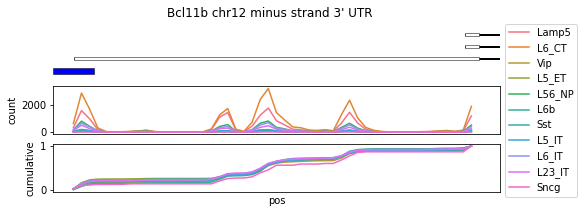

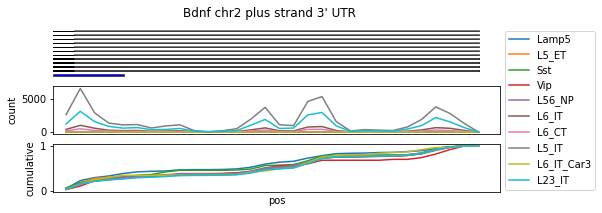

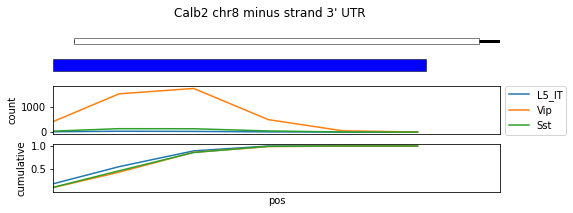

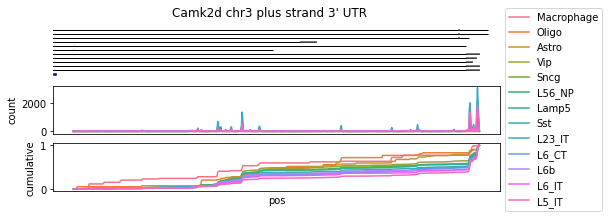

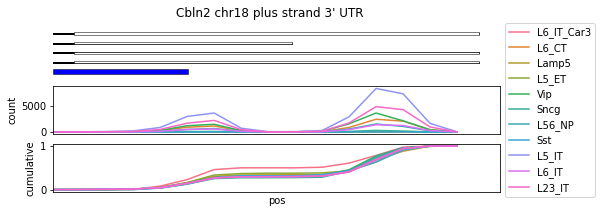

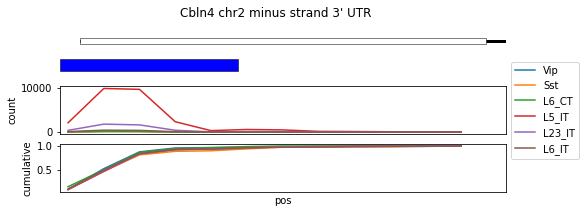

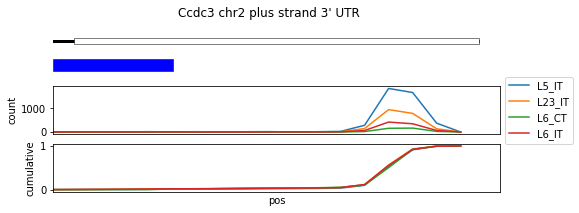

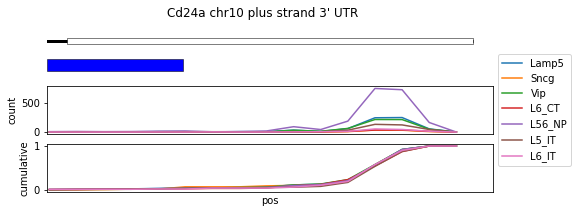

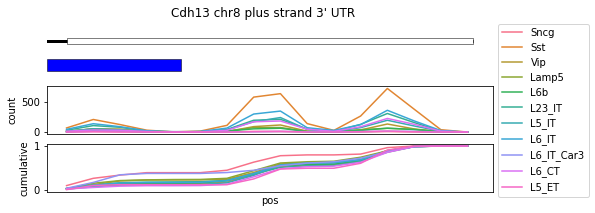

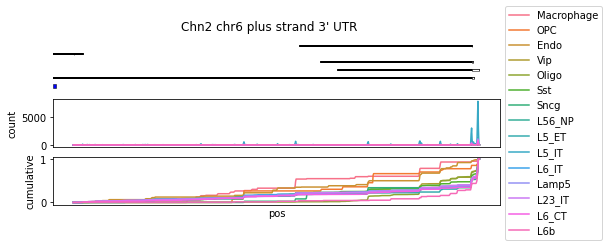

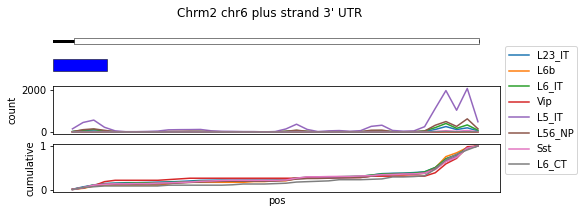

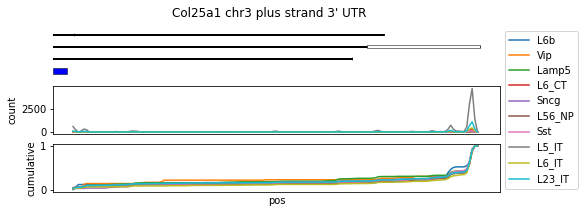

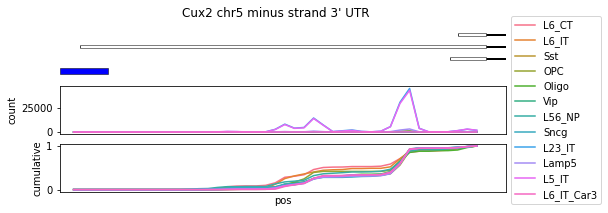

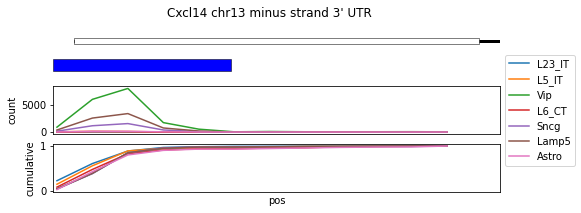

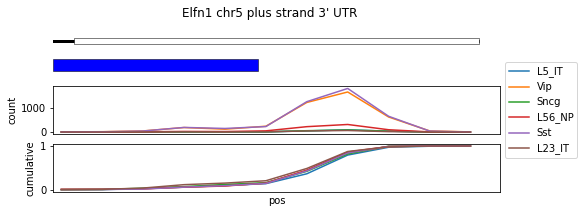

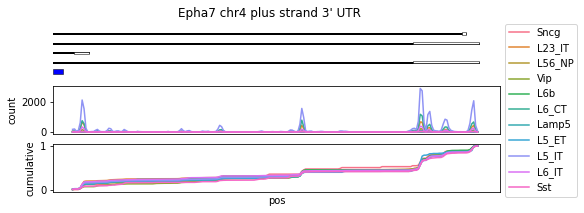

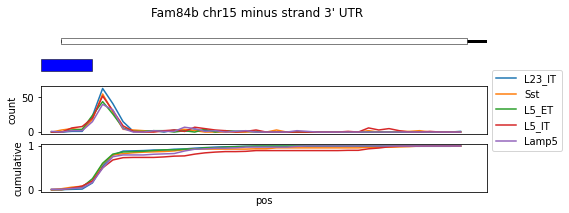

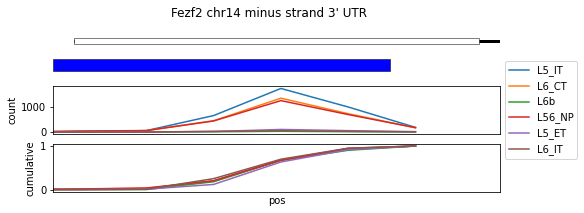

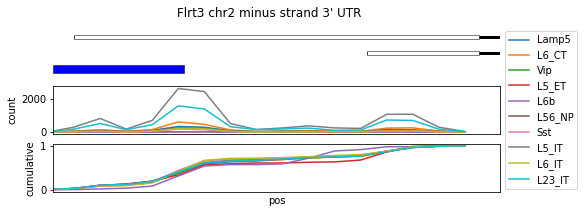

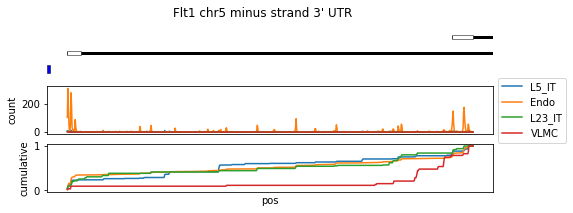

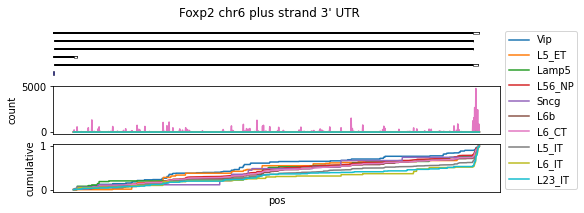

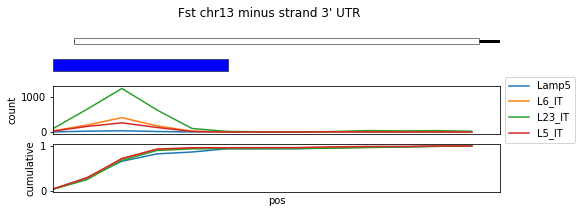

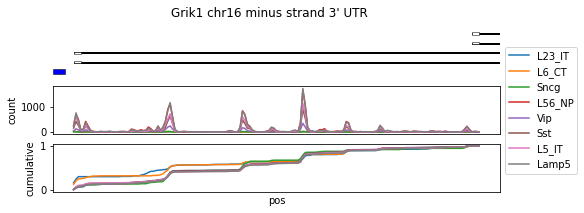

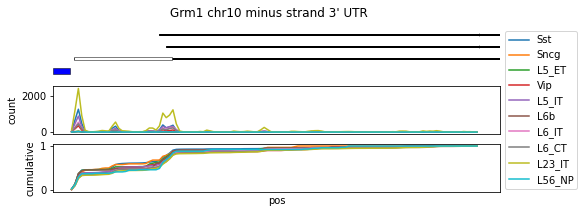

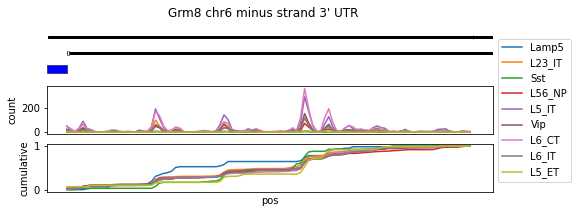

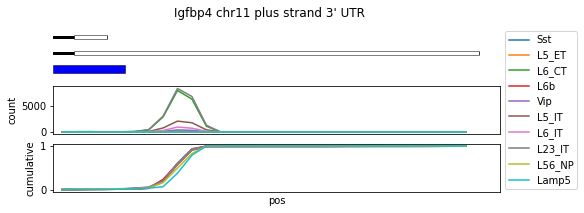

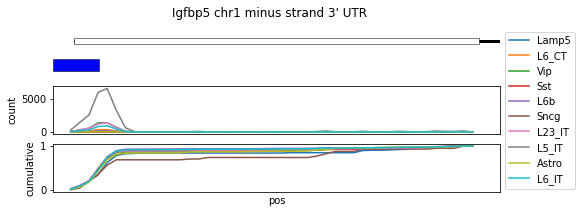

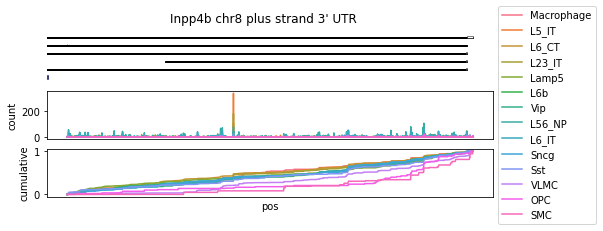

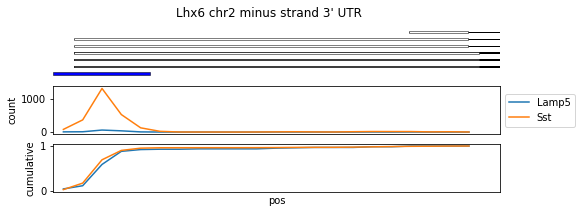

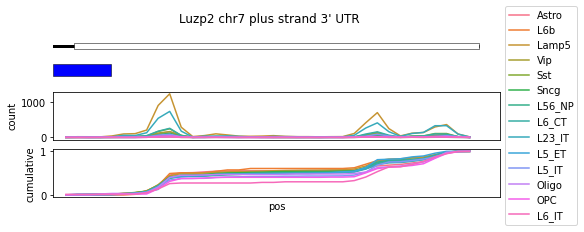

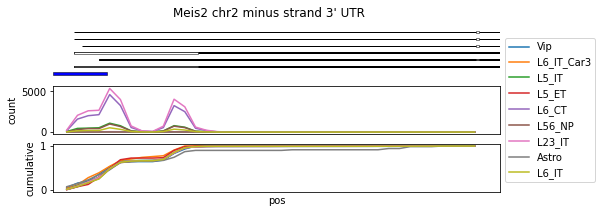

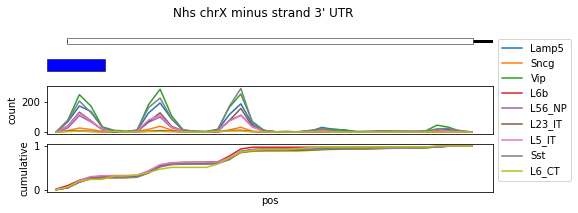

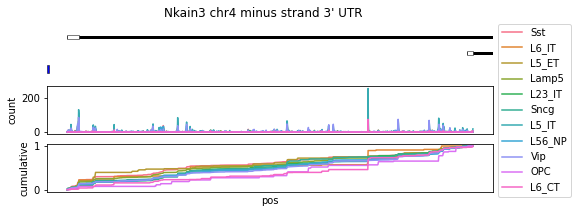

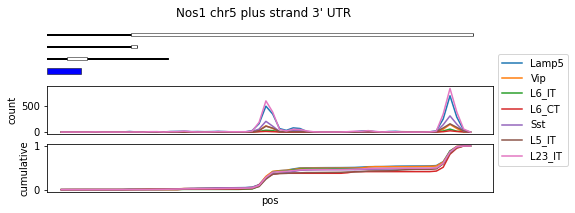

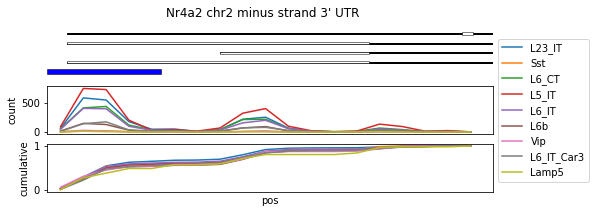

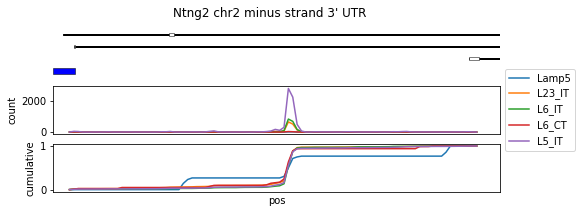

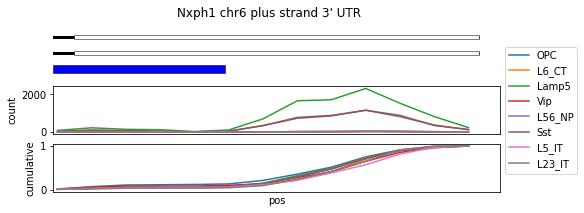

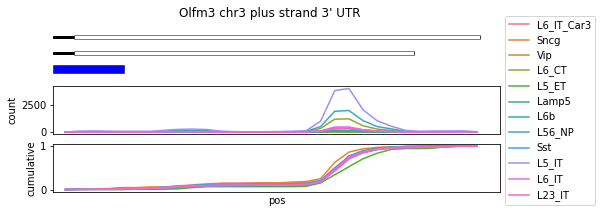

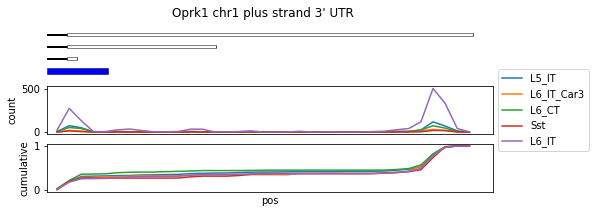

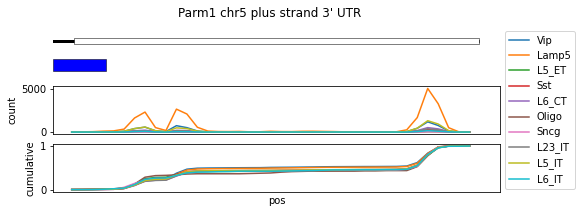

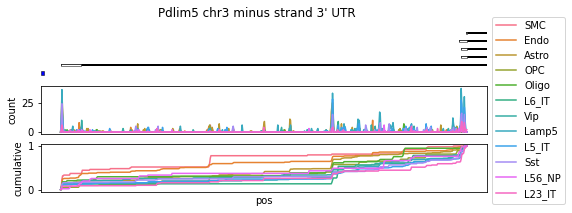

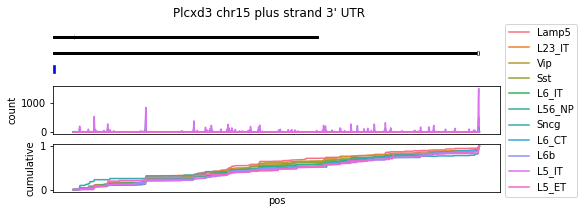

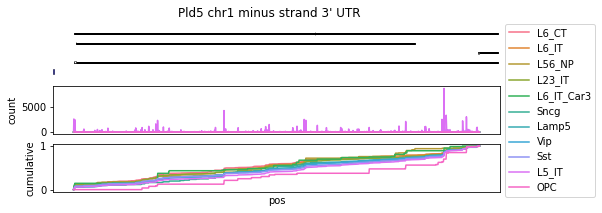

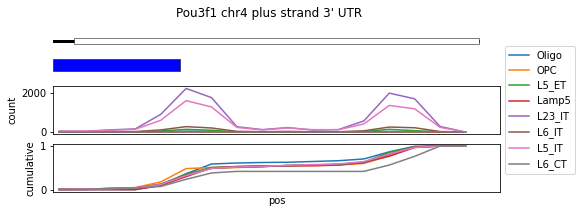

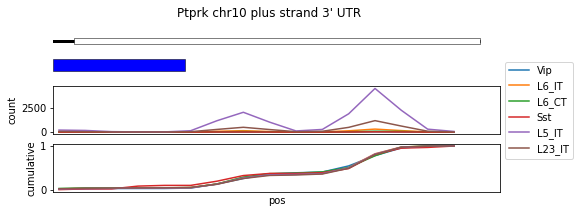

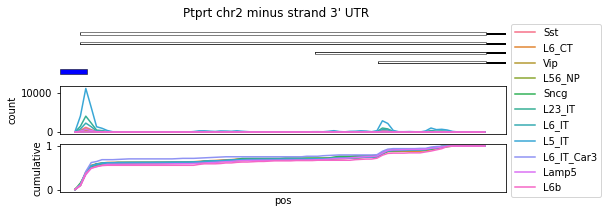

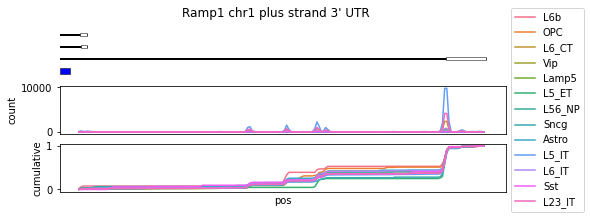

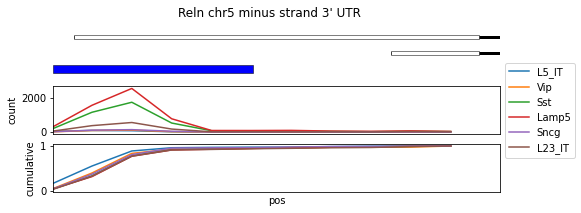

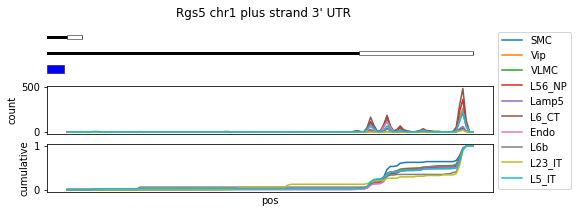

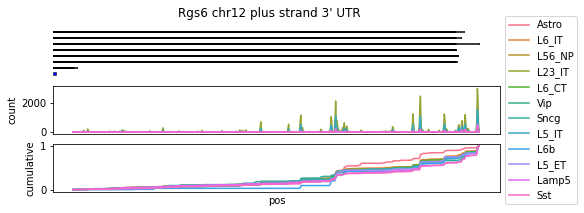

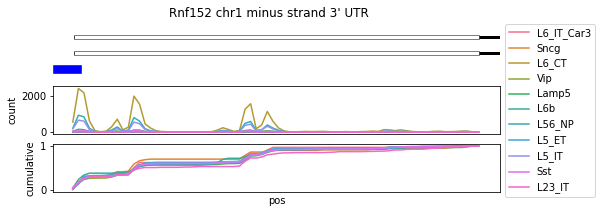

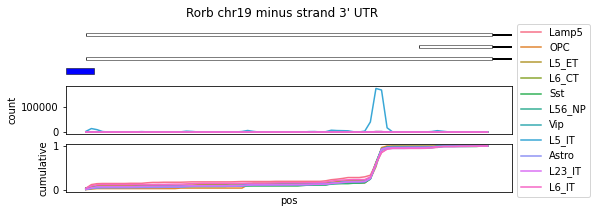

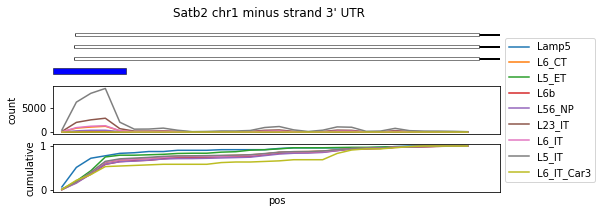

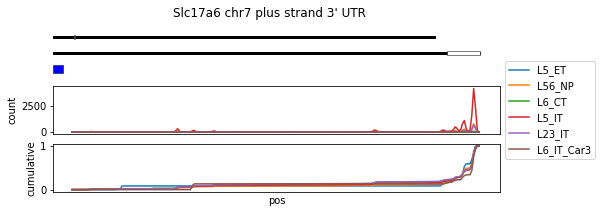

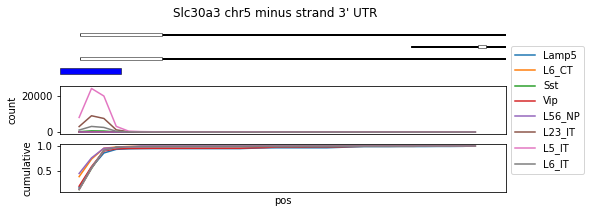

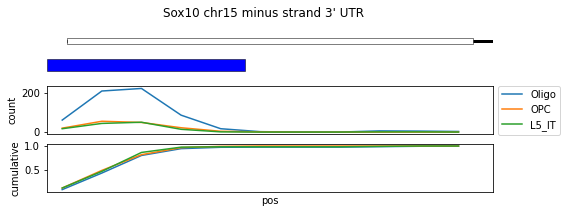

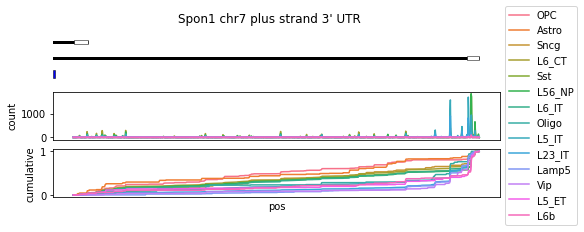

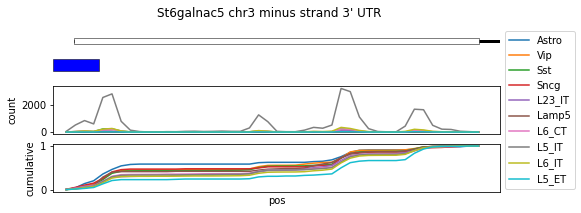

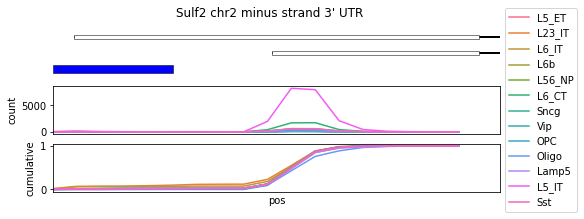

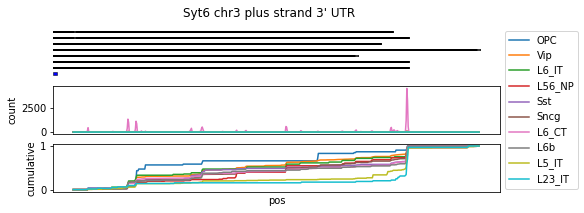

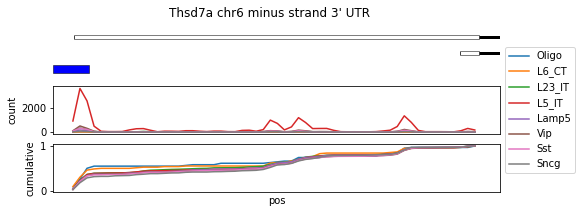

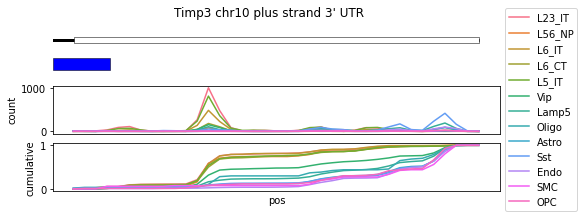

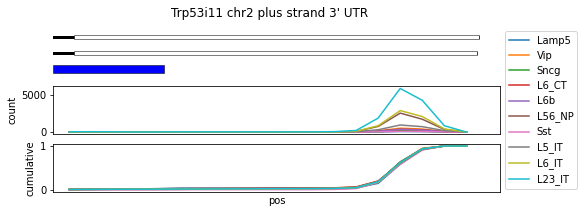

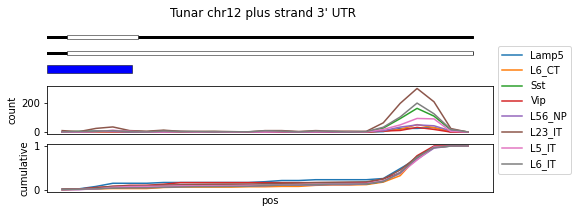

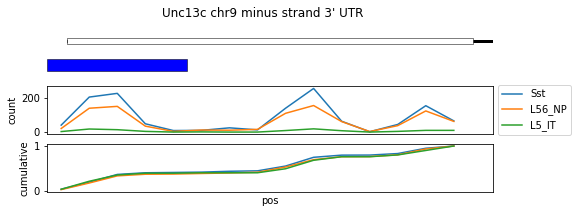

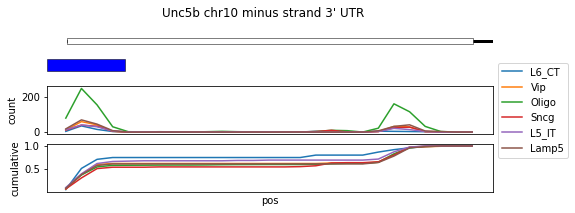

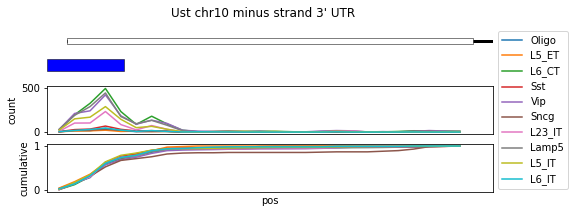

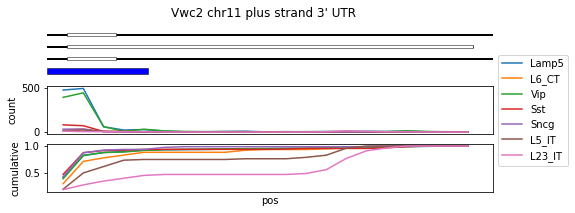

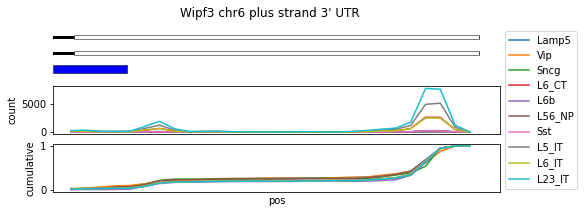

In [21]:
#genes found to be significant by SLRRP vs. ReadZs-3'-UTR
sig_genes = [
    'Bcl11b', 'Bdnf', 'Calb2', 'Camk2d', 'Cbln2', 
    'Cbln4', 'Ccdc3', 'Cd24a', 'Cdh13', 'Chn2', 
    'Chrm2', 'Col25a1', 'Cux2', 'Cxcl14', 'Elfn1', 
    'Epha7', 'Fam84b', 'Fezf2', 'Flrt3', 'Flt1', 'Foxp2', 
    'Fst', 'Grik1', 'Grm1', 'Grm8', 'Igfbp4', 'Igfbp5',
    'Inpp4b', 'Lhx6', 'Lsp1', 'Luzp2', 'Meis2', 'Nhs',
    'Nkain3', 'Nos1', 'Nr4a2', 'Ntng2', 'Nxph1', 'Olfm3',
    'Oprk1', 'Parm1', 'Pdlim5', 'Plcxd3', 'Pld5', 'Pou3f1',
    'Ptprk', 'Ptprt', 'Ramp1', 'Reln', 'Rgs5', 'Rgs6',
    'Rnf152', 'Rorb', 'Satb2', 'Slc17a6', 'Slc30a3',
    'Sox10', 'Spon1', 'St6galnac5', 'Sulf2', 'Syt6',
    'Thsd7a', 'Timp3', 'Trp53i11', 'Tunar', 'Unc13c',
    'Unc5b', 'Ust', 'Vwc2', 'Wipf3',
]

#
pdf = matplotlib.backends.backend_pdf.PdfPages('20220316_sig_genes_UTR_CDFs.pdf')

for gene in sig_genes:
    fig = plot_read_buildup_3UTR(gene,merf_gtf,mouse_onts,ws=100,count_threshold=50,scale_bar_size=500)
    if fig:
        pdf.savefig(bbox_inches='tight')
        plt.show()
    plt.close()
    
pdf.close()

In [23]:
len(sig_genes)

70

Glutamatergic celltypes have left-shifted Timp3 3' UTR usage

L5/6 NP': 'Glutamatergic'
L5 IT': 'Glutamatergic'
L2/3 IT': 'Glutamatergic'
L6 CT': 'Glutamatergic'

Vip': 'GABAergic'

Endo: 'Non-Neuronal'
Sst: 'GABAergic'
Astro: 'Non-Neuronal

In [51]:
meta_df = pd.read_csv('../../../readzs_fork/MOp_10Xv3_metadata.tsv',sep='\t')
meta_df = meta_df.drop_duplicates('subclass_label')
subclass_to_class = dict(meta_df[['subclass_label','class_label']].values)
subclass_to_class

{'Astro': 'Non-Neuronal',
 'Endo': 'Non-Neuronal',
 'L2/3 IT': 'Glutamatergic',
 'L5 ET': 'Glutamatergic',
 'L5 IT': 'Glutamatergic',
 'L5/6 NP': 'Glutamatergic',
 'L6 CT': 'Glutamatergic',
 'L6 IT': 'Glutamatergic',
 'L6 IT Car3': 'Glutamatergic',
 'L6b': 'Glutamatergic',
 'Lamp5': 'GABAergic',
 'Macrophage': 'Non-Neuronal',
 'OPC': 'Non-Neuronal',
 'Oligo': 'Non-Neuronal',
 'Pvalb': 'GABAergic',
 'SMC': 'Non-Neuronal',
 'Sncg': 'GABAergic',
 'Sst': 'GABAergic',
 'VLMC': 'Non-Neuronal',
 'Vip': 'GABAergic'}

# Creating PDFs for output

In [290]:
%time

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages('Mouse4_custom_read_buildups.pdf')
                                               
for i,gene in enumerate(merf_gtf['gene_name'].unique()):
    print(gene,i)
    fig = plot_read_buildup(gene,merf_gtf,mouse_onts,ws=100,scale_bar_size=5000)
    pdf.savefig(bbox_inches='tight')
    plt.close()
    
pdf.close()

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs
Oprk1
Sulf1
Slco5a1
Pou3f3
Satb2
Ikzf2
Igfbp5
Asic4
Ramp1
Cdh20
Rnf152
Lypd1
Tmem163
Brinp3
Rgs5
Adamts4
Pld5
Prox1
Olah
Ccdc3
C1ql3
Mrc1
Nxph2
Ntng2
Lhx6
Tnfaip6
Nr4a2
Cobll1
Cdca7
Pde11a
Trp53i11
Bdnf
Meis2
Prokr2
Flrt3
Syndig1
Slc32a1
Ptprt
Sulf2
Kcng1
Tshz2
Cbln4
Car3
Egfem1
Frem2
Trpc4
Sertm1
Clrn1
Plch1
Rxfp1
Pdgfc
Npy2r
Ctss
Syt6
Fndc7
Olfm3
Prss12
Ndst4
Camk2d
Col25a1
Npnt
Bmpr1b
Pdlim5
Col24a1
St6galnac5
Slc44a5
Ptger3
Tox
Nkain3
Epha7
1700022I11Rik
Col15a1
Grin3a
Ror1
Pou3f1
Rspo1
Marcksl1
Ptpru
Zfp804b
Sema3e
Reln
Otof
Slc30a3
C1qtnf7
Corin
Pdgfra
Parm1
Prdm8
Hpse
Nos1
Cux2
Elfn1
Flt1
Rxfp2
Slc25a13
Nxph1
Thsd7a
Foxp2
Grm8
Chrm2
Chn2
Wipf3
Crhr2
Prok2
Rerg
Kcnj8
Npas1
Ceacam9
Fosb
Dmkn
Myh14
Mrgprx2
Slc17a6
Luzp2
Nr2f2
Cemip
Prss23
Lmo1
Spon1
Sox6
Il4ra
Lsp1
Igf2
Th
Unc5d
Enpp6
Tenm3
March1
Inpp4b
Calb2
Cdh13
Crispld2
Npsr1
Barx2
Ubash3b
Nnmt
1810046K07Rik
Cspg4
Cplx3
Unc13c
Ltf
Lyzl4
Cdcp1
Ust
Grm1
Phactr2
Moxd1


Oprk1 0
Sulf1 1
Slco5a1 2
Pou3f3 3
Satb2 4
Ikzf2 5
Igfbp5 6
Asic4 7
Ramp1 8
Cdh20 9
Rnf152 10
Lypd1 11
Tmem163 12
Brinp3 13
Rgs5 14
Adamts4 15
Pld5 16
Prox1 17
Olah 18
Ccdc3 19
C1ql3 20
Mrc1 21
Nxph2 22
Ntng2 23
Lhx6 24
Tnfaip6 25
Nr4a2 26
Cobll1 27
Cdca7 28
Pde11a 29
Trp53i11 30
Bdnf 31
Meis2 32
Prokr2 33
Flrt3 34
Syndig1 35
Slc32a1 36
Ptprt 37
Sulf2 38
Kcng1 39
Tshz2 40
Cbln4 41
Car3 42
Egfem1 43
Frem2 44
Trpc4 45
Sertm1 46
Clrn1 47
Plch1 48
Rxfp1 49
Pdgfc 50
Npy2r 51
Ctss 52
Syt6 53
Fndc7 54
Olfm3 55
Prss12 56
Ndst4 57
Camk2d 58
Col25a1 59
Npnt 60
Bmpr1b 61
Pdlim5 62
Col24a1 63
St6galnac5 64
Slc44a5 65
Ptger3 66
Tox 67
Nkain3 68
Epha7 69
1700022I11Rik 70
Col15a1 71
Grin3a 72
Ror1 73
Pou3f1 74
Rspo1 75
Marcksl1 76
Ptpru 77
Zfp804b 78
Sema3e 79
Reln 80
Otof 81
Slc30a3 82
C1qtnf7 83
Corin 84
Pdgfra 85
Parm1 86
Prdm8 87
Hpse 88
Nos1 89
Cux2 90
Elfn1 91
Flt1 92
Rxfp2 93
Slc25a13 94
Nxph1 95
Thsd7a 96
Foxp2 97
Grm8 98
Chrm2 99
Chn2 100
Wipf3 101
Crhr2 102
Prok2 103
Rerg 104
Kcnj8 105
Npas

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


Cplx3 138


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


Unc13c 139


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


Ltf 140


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


Lyzl4 141
Cdcp1 142
Ust 143
Grm1 144
Phactr2 145
Moxd1 146
Ptprk 147
Hs3st5 148
Ccdc162 149
Cd24a 150
Unc5b 151
Egr2 152
Timp3 153
Ano4 154
Slc17a8 155
Tmtc2 156
Fam19a2 157
Nxph4 158
Vwc2 159
Egfr 160
5730522E02Rik 161
Adra1b 162
Sgcd 163
Adamts2 164
Col23a1 165
Glra1 166
Serpinf1 167
Vtn 168
B4galnt2 169
Tcap 170
Igfbp4 171
Gfap 172
Cacng5 173
Osr1 174
Egln3 175
Plekhg3 176
Rgs6 177
Tunar 178
Bcl11b 179
Vipr2 180
Sp8 181
Itgb8 182
Pou6f2 183
Scgn 184
Pxdc1 185
Cxcl14 186
Iqgap2 187
Ccnb1 188
Fst 189
Dnase1l3 190
Fezf2 191
Chat 192
Sncg 193
Adam2 194
Chrna2 195
Pcdh8 196
Tbc1d4 197
Gpc6 198
Plcxd3 199
Cdh12 200
Sema5a 201
Col14a1 202
Fam84b 203
Sox10 204
Wnt7b 205
Syt10 206
Nr4a1 207
Cldn5 208
Teddm3 209
Muc20 210
Ccdc80 211
Chodl 212
Grik1 213
Thbs2 214
Daam2 215
Ptprm 216
L3mbtl4 217
Lama3 218
Aqp4 219
Cd14 220
Prr16 221
Ccbe1 222
Cbln2 223
Rorb 224
Rfx3 225
Acta2 226
Blnk 227
Opalin 228
Bgn 229
Il1rapl2 230
Nhs 231


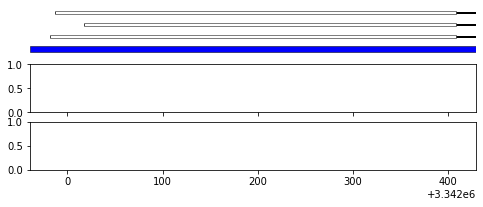

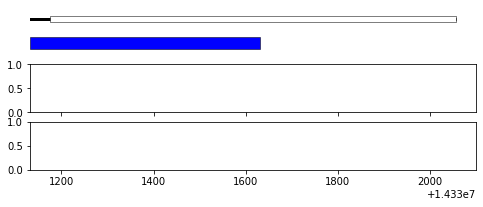

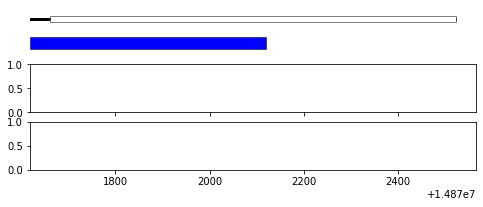

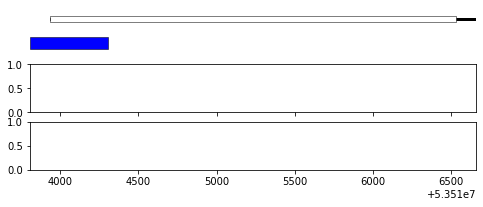

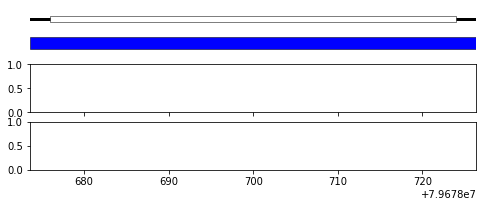

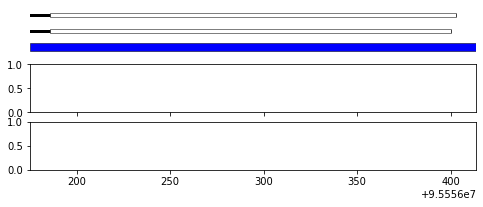

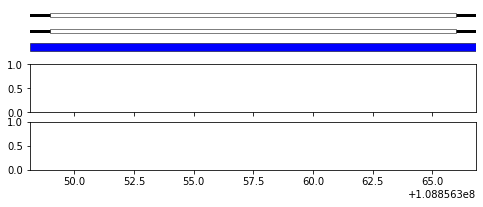

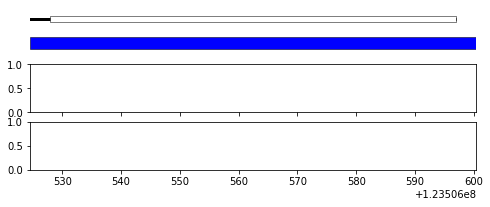

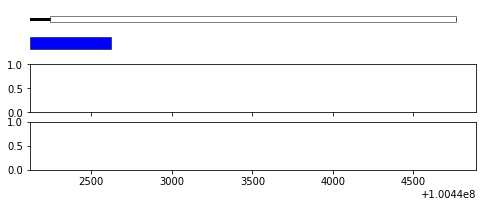

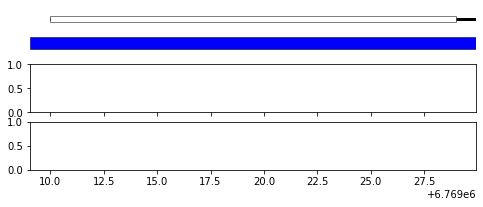

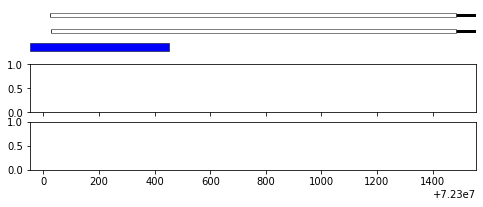

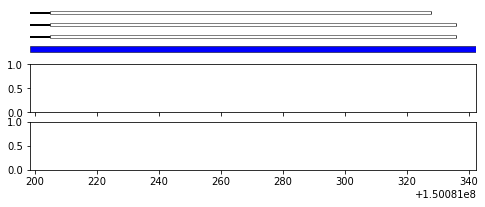

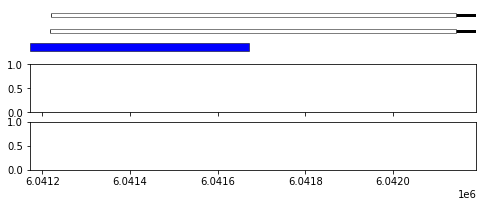

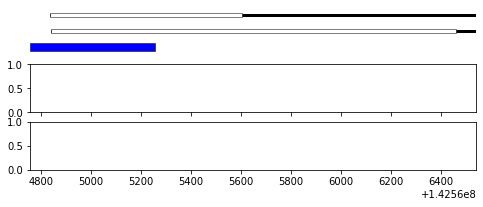

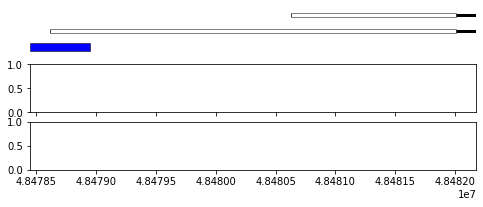

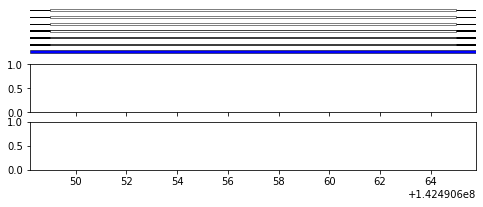

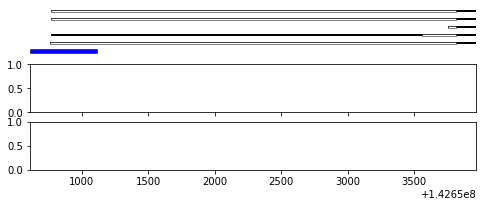

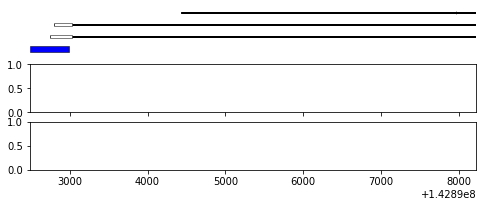

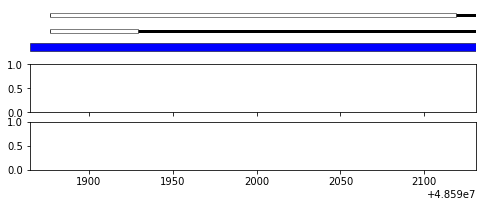

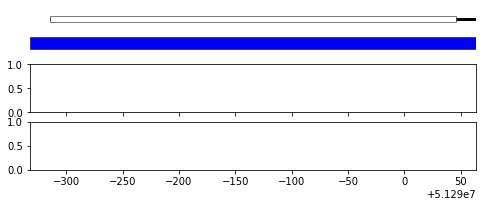

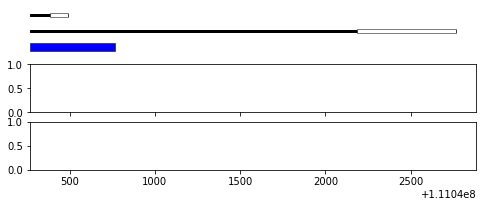

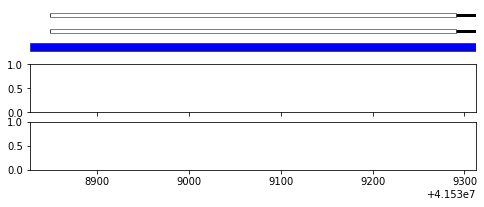

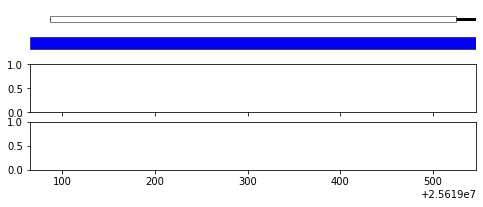

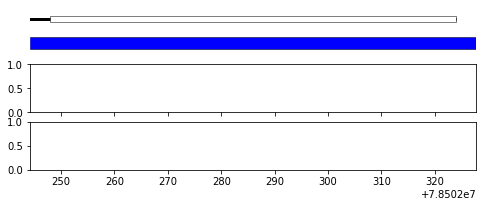

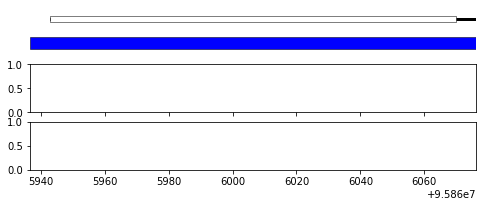

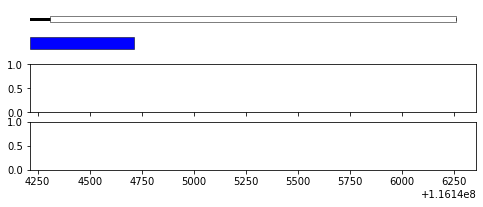

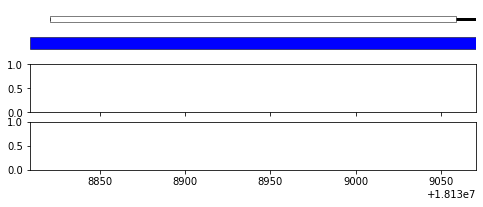

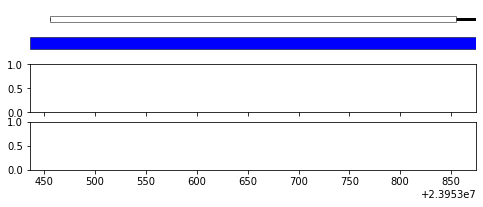

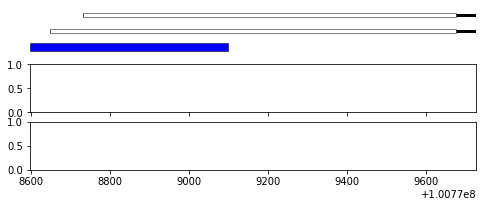

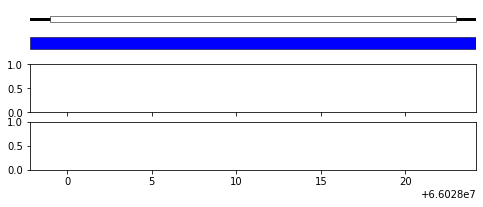

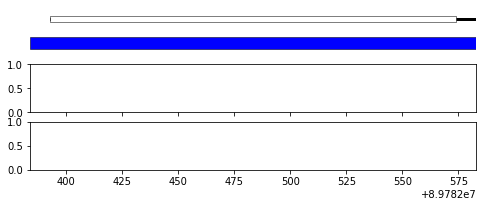

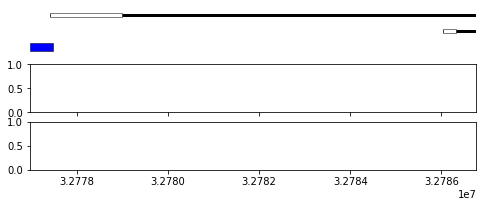

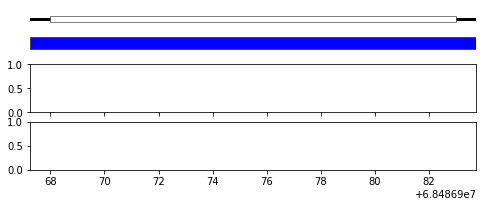

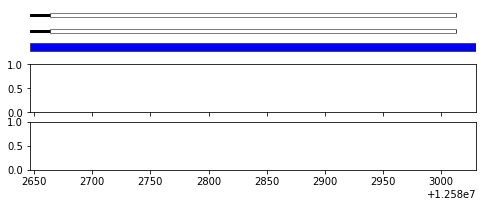

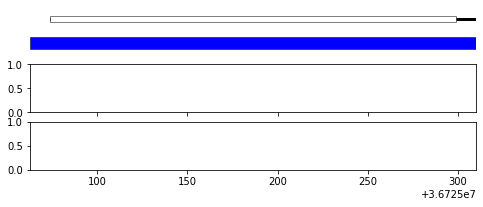

In [61]:
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages('Mouse1_3UTR_read_buildups.pdf')
                                               
for i,gene in enumerate(merf_gtf['gene_name'].unique()):
    print(gene,i)
    fig = plot_read_buildup_3UTR(gene,merf_gtf,mouse_onts,ws=100,count_threshold=50,scale_bar_size=500)
    if fig:
        pdf.savefig(bbox_inches='tight')
        plt.close()
    
pdf.close()


plt.show()
plt.close()

In [286]:
timp3_window_df = pd.read_csv(
    '/oak/stanford/groups/horence/rob/readzs_fork/results/timp3_windows.txt',
    sep='\t',
)
timp3_window_df['mouse'] = timp3_window_df['ontology'].str.split('___').str[1]
timp3_window_df['ontology'] = timp3_window_df['ontology'].str.split('___').str[0]

cs = [
    'window', 'mouse', 'ontology', 
    'significant', 'chi2_p_val','perm_p_val', 'median_z_scaled',
    'sum_counts_per_window_per_ont', 'med_counts_per_window_per_ont',
    'medians_range',
]

timp3_window_df = timp3_window_df[
    timp3_window_df['window'].eq('chr10_17270_plus')
].sort_values('mouse')[cs]

timp3_window_df

,window,mouse,ontology,significant,chi2_p_val,perm_p_val,median_z_scaled,sum_counts_per_window_per_ont,med_counts_per_window_per_ont,medians_range
11,chr10_17270_plus,427378,Astro,False,3.441691e-15,0.16,0.300570,43,6.0,0.265200
14,chr10_17270_plus,427378,Lamp5,False,3.441691e-15,0.16,0.170552,211,6.5,0.265200
16,chr10_17270_plus,427378,Sst,False,3.441691e-15,0.16,0.371836,1227,12.0,0.265200
18,chr10_17270_plus,427378,Vip,False,3.441691e-15,0.16,0.106636,197,7.0,0.265200
12,chr10_17270_plus,457911,Astro,NaN,9.999912e-01,NaN,0.310350,40,6.0,0.295431
13,chr10_17270_plus,457911,Endo,NaN,9.999912e-01,NaN,0.034209,154,12.0,0.295431
15,chr10_17270_plus,457911,Lamp5,NaN,9.999912e-01,NaN,0.017051,67,5.0,0.295431
17,chr10_17270_plus,457911,Sst,NaN,9.999912e-01,NaN,0.184128,1160,9.0,0.295431
19,chr10_17270_plus,457911,Vip,NaN,9.999912e-01,NaN,0.014919,95,6.0,0.295431


In [283]:
timp3_window_df.columns

Index(['window', 'ontology', 'sum_counts_per_window_per_ont',
       'med_counts_per_window_per_ont', 'median_z_scaled', 'chi2_p_val',
       'perm_p_val', 'significant', 'medians_range', 'mouse'],
      dtype='object')

,window,mouse,ontology
11,chr10_17270_plus,427378,Astro
14,chr10_17270_plus,427378,Lamp5
16,chr10_17270_plus,427378,Sst
18,chr10_17270_plus,427378,Vip
12,chr10_17270_plus,457911,Astro
13,chr10_17270_plus,457911,Endo
15,chr10_17270_plus,457911,Lamp5
17,chr10_17270_plus,457911,Sst
19,chr10_17270_plus,457911,Vip


# Preparing bed for 3' UTRs

In [13]:
utrs = pd.read_csv('/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/plotting/three_prime_UTRs.csv')
utrs.head()

,chrom,source,kind,start,stop,dot1,strand,dot2,info,gene_name,transcript_id
0,chr1,HAVANA,three_prime_UTR,5602785,5606131,.,+,.,ID=UTR3:ENSMUST00000160777.7;Parent=ENSMUST000...,Oprk1,ENSMUST00000160777.7
1,chr1,HAVANA,three_prime_UTR,5602785,5602866,.,+,.,ID=UTR3:ENSMUST00000027038.10;Parent=ENSMUST00...,Oprk1,ENSMUST00000027038.10
2,chr1,HAVANA,three_prime_UTR,5602785,5604014,.,+,.,ID=UTR3:ENSMUST00000160339.1;Parent=ENSMUST000...,Oprk1,ENSMUST00000160339.1
3,chr1,HAVANA,three_prime_UTR,12858843,12861192,.,+,.,ID=UTR3:ENSMUST00000177608.7;Parent=ENSMUST000...,Sulf1,ENSMUST00000177608.7
4,chr1,HAVANA,three_prime_UTR,12858843,12860371,.,+,.,ID=UTR3:ENSMUST00000180062.7;Parent=ENSMUST000...,Sulf1,ENSMUST00000180062.7


In [15]:
bed_example = pd.read_csv('/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/plotting/buildup_plots/MERFISH_genes.bed',sep=' ')
bed_example.head()

,#chr,start,end,gene,strand
0,chr1,5588466,5606131,Oprk1,+
1,chr1,12692277,12861192,Sulf1,+
2,chr1,12866549,12992650,Slco5a1,-
3,chr1,42695768,42703176,Pou3f3,+
4,chr1,56793981,56978650,Satb2,-


In [17]:
#a single gene can have multiple 3' UTRs
utrs.groupby('gene_name').size().sort_values(ascending=False)

gene_name
Camk2d     34
Ano4       31
Inpp4b     24
Syt6       20
Bmpr1b     13
           ..
Parm1       1
Pde11a      1
Plekhg3     1
Pou3f1      1
Mrc1        1
Length: 232, dtype: int64

In [23]:
#combine the multiple UTRs of a single gene taking the min/max coordinates
agg_utrs = utrs.groupby('gene_name').agg(
    chrom = ('chrom','first'),
    start = ('start','min'),
    end = ('stop','max'),
    gene = ('gene_name','first'),
    strand = ('strand','first'),
).reset_index()

agg_utrs.head()

,gene_name,chrom,start,end,gene,strand
0,1700022I11Rik,chr4,42974221,42983640,1700022I11Rik,+
1,1810046K07Rik,chr9,51289686,51290046,1810046K07Rik,-
2,5730522E02Rik,chr11,25619087,25619525,5730522E02Rik,-
3,Acta2,chr19,34241090,34241666,Acta2,-
4,Adam2,chr14,66027329,66028023,Adam2,-


In [24]:
agg_utrs = agg_utrs.drop(columns=['gene_name'])
agg_utrs = agg_utrs.rename(columns={'chrom':'#chr'})
agg_utrs.head()

,#chr,start,end,gene,strand
0,chr4,42974221,42983640,1700022I11Rik,+
1,chr9,51289686,51290046,1810046K07Rik,-
2,chr11,25619087,25619525,5730522E02Rik,-
3,chr19,34241090,34241666,Acta2,-
4,chr14,66027329,66028023,Adam2,-


In [25]:
agg_utrs.to_csv('/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/plotting/buildup_plots/MERFISH_3UTRs.bed',sep=' ')